# Generate a coupled 1D(2D)-RR model

### Load Python libraries

In [1]:
# Basis
import os
import sys
import shutil
import numpy as np

sys.path.append('../')       
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# For reading SOBEK results as boundary conditions
# hkvsobekpy requires the modules fire and tqdm, install these (conda install fire tqdm)
import hkvsobekpy

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString, Point

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

### Set some paths to access data

In [2]:
# path to the package containing the dummy-data
data_path = os.path.abspath('../data')

# path to dflowfm for refining the mesh 
dflowfm_path = os.path.abspath(r'..')

# path to write the models
output_path = os.path.abspath('.')

# path to DIMR for a correct run.bat file
dimr_path = r'<PUT YOUR PATH TO DIMR HERE>\x64\dimr\scripts\run_dimr.bat'

## Recreate the 1D/2D model

Hide by clicking on the blue sidebar

In [3]:
# read data from HyDAMO database
hydamo = HyDAMO(extent_file=os.path.join(data_path,'gis/selectie_pilot.shp'))
hydamo.branches.read_gml(os.path.join(data_path,'gml/hydroobject.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.branches['ruwheidstypecode'] = 4
hydamo.crosssections.read_gml(os.path.join(data_path,'gml/dwarsprofiel.gml') , 
                              column_mapping={'ruwheidswaardelaag':'ruwheidswaarde'} ,
                              index_col='profielcode' ,
                              groupby_column='profielcode' , 
                              order_column='codevolgnummer')
hydamo.crosssections.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.crosssections.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.crosssections.drop('code', axis=1, inplace=True)
hydamo.crosssections.rename(columns={'profielcode': 'code'}, inplace=True)
hydamo.parametrised_profiles.read_gml(os.path.join(data_path,'gml/NormGeparametriseerdProfiel.gml'), column_mapping={'ruwheidswaardelaag': 'ruwheidswaarde'})
hydamo.parametrised_profiles.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.parametrised_profiles.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.bridges.read_gml(os.path.join(data_path,'gml/brug.gml'))
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.culverts.read_gml( os.path.join(data_path,'gml/duikersifonhevel.gml'),  index_col='code',  column_mapping={'vormkoker': 'vormcode'},  clip=hydamo.clipgeo)
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])
duikers_rekentijd = ['RS372-KDU3','RS375-KDU2','RS373-KDU7','RS373-KDU20','RS373-KDU22','RS373-KDU19']
duikers_gemalen = ['OWL32921-KDU3','RS375-KDU6']             
hydamo.culverts.drop(duikers_rekentijd, axis=0, inplace=True)
hydamo.culverts.drop(duikers_gemalen, axis=0, inplace=True)
hydamo.weirs.read_gml(os.path.join(data_path,'gml/stuw.gml'))
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.orifices.read_gml(os.path.join(data_path,'gml/onderspuier.gml'))
hydamo.orifices.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=2)
hydamo.orifices.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.afsluitmiddel.read_gml(os.path.join(data_path,'gml/afsluitmiddel.gml'), index_col='code')
hydamo.gemalen.read_gml(os.path.join(data_path,'gml/gemaal.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.read_gml(os.path.join(data_path,'gml/pomp.gml'), index_col='code', clip=hydamo.clipgeo)
hydamo.pumps.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5)
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.sturing.read_gml(os.path.join(data_path,'gml/sturing.gml'), index_col='code')

# initialize 1D DflowFMModel-object
dfmmodel = DFlowFMModel()
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, hydamo.afsluitmiddel)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, yz_profiles=hydamo.crosssections, parametrised_profiles=hydamo.parametrised_profiles)
dfmmodel.structures.io.orifices_from_hydamo(hydamo.orifices)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.sturing, gemalen=hydamo.gemalen)
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=40.0, seperate_structures=True)
dfmmodel.crosssections.io.from_hydamo(dwarsprofielen=hydamo.crosssections,parametrised=hydamo.parametrised_profiles, branches=hydamo.branches)
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30)
dfmmodel.crosssections.set_default_definition(definition=default, shift=8.0)

# initialize 2D-grid
# mesh = Rectangular()
# cellsize=25
# mesh.generate_within_polygon(hydamo.clipgeo, cellsize=cellsize, rotation=0)
# buffered_branch = hydamo.branches.loc[['riv_RS1_1810', 'riv_RS1_264'], 'geometry'].unary_union.buffer(10)
# mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=dflowfm_path)
# rasterpath = os.path.join(data_path,'rasters/dommel_25m.tif')
# mesh.altitude_from_raster(rasterpath)
# dfmmodel.network.add_mesh2d(mesh)

# # 1D-2D links
# del dfmmodel.network.links1d2d.faces2d[:]
# del dfmmodel.network.links1d2d.nodes1d[:]
# dfmmodel.network.links1d2d.generate_1d_to_2d(max_distance=50)

# boundary/initial conditions
bcs = pd.read_csv(os.path.join(data_path,'sobekdata/boundaryconditions.csv'), sep=';', index_col=0)
bcs.index = pd.to_datetime(bcs.index)
dfmmodel.external_forcings.add_boundary_condition(  name='BC_flow_in', pt=(140712.056047, 391893.277878),  bctype='discharge',  series=bcs['Discharge'])
dfmmodel.external_forcings.add_boundary_condition( name='BC_wlev_down',  pt=(141133.788766, 395441.748424),  bctype='waterlevel', series=bcs['Waterlevel'])
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

# add observation points
#dfmmodel.observation_points.add_points([Point((141150, 393700)),(141155, 393705),Point((145155, 394705)),(145150, 394700)],['ObsPt1','ObsPt2','ObsPt2D1','ObsPt2D2'], locationTypes=['1d','1d','2d','2d'])
dfmmodel.observation_points.add_points([Point((141150, 393700)),(141155, 393705)],['ObsPt1','ObsPt2'], locationTypes=['1d','1d'])

2021-07-07 12:14:33,306 - delft3dfmpy.converters.hydamo_to_dflowfm - hydamo_to_dflowfm - INFO - Currently only simple weirs can be applied. From Hydamo the attributes 'laagstedoorstroomhoogte' and 'kruinbreedte' are used to define the weir dimensions.
2021-07-07 12:14:33,438 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.
2021-07-07 12:14:33,441 - delft3dfmpy.core.dfm - dfm - WARNING - Structures UWeir_Test2, Orifice_Test1 have the same location.
2021-07-07 12:14:33,443 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch riv_RS1_264 at: [0.0, 104.16550000000001, 348.33320917846794], due to the structures at [-0.001, 104.147, 104.184, 348.3342091784679].
2021-07-07 12:14:33,447 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch riv_RS373_2442 at: [0.0, 258.68399999999997, 1369.5082649188546], due to the structures at [-0.001, 251.394, 265.974, 306.452, 374.187, 584.463, 722.824, 866.662, 1059.317, 1149.342, 1289.363, 

## Generate the RR-model

Catchments are provided as HyDAMO files and are read similarly as the FM files are. They can be GML or shape files. Note that in case of shapefiles column mapping is necessary because the column names are truncated. Required columns include 'code' as the ID and 'lateraleknoopcode' as the associated FM boundary node ID. 

Note that when catchments have a "MultiPolygon' geometry, the multipolygons are 'exploded' into single polygon geometries. A warning of this is isued, and a suffix is added to every polygon-ID to prevent duplicates. This is the case for both GML and SHP input.

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.
 
At the moment, two options exist for the schematisation of the paved area:
 1) simple: the paved fraction of each catchment is modelled with a paved node, directly connected to catchments' boundary node
 <br>
 2) complex: serer area polygons and overflow points are used a input as well. For each sewer area, the paved areas in the intersecting catchments are summed. This total area is then distributed over the overflows that are associated with the sewer area (the column 'lateraleknoopcode') using the area fraction (column 'fractie') for each overflow. In each cathment, paved area that does not intersect with a sewer area gets an unpaved node as in option (1).

In [4]:
# RR-catchments
hydamo.catchments.read_shp(os.path.join(data_path,'gml/afvoergebied_2.shp'), index_col='code', 
                           clip=None, column_mapping={'lateralekn' : 'lateraleknoopcode', 'administra':'administratiefgebied'})

Optionally, read also sewer areas and overflow locations. If sewer-areas are used, there must also be overflows and vice versa.

In [5]:
hydamo.sewer_areas.read_shp(os.path.join(data_path,'gml/rioleringsgebieden.shp'), index_col='code',clip=None, check_geotype=False)
hydamo.overflows.read_shp(os.path.join(data_path,'gml/overstorten.shp'), index_col='code', clip=None, column_mapping={'codegerel':'codegerelateerdobject', 'Naam':'name' })
# snap the overflows to 1D branches
hydamo.overflows.snap_to_branch(hydamo.branches, snap_method='overal', maxdist= 5)

Other input data for RR can be fed by rasters (from which zonal statistics will be extracted) or spatially uniform default values. Three rasters are required: land use, soil type and surface elevation. For each land use type, the area within each catchment is calculated. Surface level is calculated as the median within the catchment, and the most-occurring soil type is used. In all rasters, a NODATA-value of -999 should be used.

An RR-model object must first be initialized:

In [6]:
drrmodel = DFlowRRModel()

#### Unpaved nodes

The coding for the land use types needs to be as follows:<br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in m+NAP.

In [7]:
# all data and settings to create the RR-model
lu_file = os.path.join(data_path,'rasters/lgn250_greenhouse.tif')
ahn_file = os.path.join(data_path,'rasters/dommel_25m.tif')
soil_file = os.path.join(data_path,'rasters/soiltypes250.tif')

Other parameters can be set by rasters (i.e. spatially distributed) or uniform. If a number is provided, the module will use this number for all catchments, if a string is provided it is interpreted as a raster file name. For unpaved nodes, these parameters are the storage on the surface, the infiltration capacity, and the initial ground water depth (in m below the surface). The parametrisation for Ernst is taken from a list of layer depths, where each depth is assigned the corresponding resistance from the list of layer_resistances. They need to be of equal length. The resistance value for flow from open water back to unpaved (infil_resistance) and the resistance for surface runoff (runoff_resistance) can also be determined here, but they are optional: if omitted, default values of 300 d-1 (cvi) and 1 d-1 (cvs) are adopted.

In [8]:
surface_storage = 10.0
infiltration_capacity = 100.0
initial_gwd = 0.4

runoff_resistance = 1.
infil_resistance = 300.
layer_depths = [0.0, 1.0, 2.0]
layer_resistances = [30,200,10000]

The argument 'meteo_areas' to 'unpaved_from_input' contains the polygons that correspond to a meteo-station: here these are identical to each catchment so each catchment gets its own station.  If there are many, small, catchments, it might be more appropriate to use, for instance, Thiessen polygons around gauges. For each catchment, the meteo-station is based on the 'meteo-area;-feature in which the centroid of the catchment falls.


In [9]:
meteo_areas = hydamo.catchments

The argument 'zonalstats_alltouched' is rather important. It defines the number of cells in the input rasters that are taken into account for each catchment. If the raster resolution is sufficiently high, its setting does not matter. In the case of coarse rasters, small catchments might end up with no nodes at all if the 'zonalstats_alltouched' is FALSE - it says that only cells that are entirely within the catchment are taken into account. If it is TRUE, all cells that are touched by the catchment geometry are taken into account - i.e. some pixels might be counted multiple times. Note that to define average fluxes (meteo, seepage, storages) zonalstats_alltouched is TRUE by default. For elevation, land use and soil types it is FALSE by default, if the argument is omitted.

In [10]:
drrmodel.unpaved.io.unpaved_from_input(hydamo.catchments, lu_file, ahn_file, soil_file, surface_storage, infiltration_capacity, initial_gwd, meteo_areas, zonalstats_alltouched=True)
drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances,infiltration_resistance=infil_resistance, runoff_resistance=runoff_resistance)

# Or alternatively, to use default values of infiltration and runoff resistances:
#drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances)

How many unpaved nodes were schematized?

In [11]:
len([nodes for nodes in drrmodel.unpaved.unp_nodes.items() if np.sum([float(n) for n in nodes[1]['ar'].split(' ')]) > 0.0])

30

#### Paved 

Input for the paved nodes are land use -the area of the paved node is the area of class '14' in the provided land use map- and surface elevation. In addition, the following parameters can all be numbers (spatially uniform) or raster filenames:
- storage on the street <br>
- storage in the sewer system <br>
- capacity of the sewerpumps <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [12]:
street_storage = 10.0
sewer_storage =  os.path.join(data_path,'rasters/sewstor.tif')
pumpcapacity =  os.path.join(data_path,'rasters/pumpcap.tif')

To convert to a model definition, according to the simple schematisation.

In [13]:
drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
                                    landuse=lu_file, 
                                    surface_level=ahn_file,
                                    street_storage=street_storage,
                                    sewer_storage=sewer_storage,
                                    pump_capacity=pumpcapacity, 
                                    meteo_areas=meteo_areas,
                                    zonalstats_alltouched=True,
                                    overflows=hydamo.overflows,
                                    sewer_areas=hydamo.sewer_areas                                   
                                   )

How many paved nodes were schematized?

In [14]:
len([nodes for nodes in drrmodel.paved.pav_nodes.items() if float(nodes[1]['ar']) > 0.0])

22

#### Greenhouse nodes

Input for the greenhouse nodes are (again) land use -the area of the paved node is the area of class '15' in the provided land use map- and surface elevation. In addition, the following parameter can be a number (spatially uniform) or a raster filename:
- storage on the roof <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [15]:
roof_storage = os.path.join(data_path,'rasters/roofstor.tif')

To convert to a model definition:

In [16]:
drrmodel.greenhouse.io.greenhouse_from_input(hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas, zonalstats_alltouched=True)

How many greenhouse nodes were schematized?

In [17]:
len([nodes for nodes in drrmodel.greenhouse.gh_nodes.items() if float(nodes[1]['ar']) > 0.0])

10

#### Open water

Input for the open water nodes are only land use -the area of the paved node is the area of class '13' in the provided land use map. The meteo-station is assigned in the same way as for unpaved nodes.

In [18]:
# the GUI does not support open water nodes yet
drrmodel.openwater.io.openwater_from_input(hydamo.catchments, lu_file, meteo_areas, zonalstats_alltouched=True)

## Boundary nodes

Coupling between RR and FM must be online (parallel), not sequential. RR reads waterlevels from FM laterals and FM gets discharges from lateral nodes of discharge type 'realtime'. Currently, the RR-FM coupling requires that each RR-node is coupled to its own boundary node. ID's should be identical, with a suffix '_boundary'. The following function creates these nodes at locations that are snapped to the branch-network.

In [19]:
drrmodel.external_forcings.io.boundary_from_nodes( dfmmodel.network.branches,drrmodel.unpaved.unp_nodes, drrmodel.paved.pav_nodes, drrmodel.greenhouse.gh_nodes, drrmodel.openwater.ow_nodes)

The same locations also need to be added to the DFM-model. In a 1D/2D model, laterals from hydamo can be used at which timeseries are prescribed. In that case, the Hydamo laterals are the first argument of the function below. Here, laterals are created at the same locations of the RR-boundaries, so the first argument are the RR-boundaries. 

In [20]:
dfmmodel.external_forcings.io.read_laterals(drrmodel.external_forcings.boundary_nodes, lateral_discharges=None, rr_boundaries=drrmodel.external_forcings.boundary_nodes, branches=dfmmodel.network.branches)

### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

Precipitation and evaporation are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved. For seepage, as the use of Metaswap-rasters is allowed, the unit is assumed to m3/grid cell/timestep.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.

IMPORTANT: time steps are extracted from the file names. Therefore, the names should cohere to some conditions:
The filename should consist of at least two parts, separated by underscores. The second part needs to contain time information, which should be formatted as YYYYMMDDHHMMSS (SS may be omitted). Or, for daily data YYYYMMDD.

For example: 'precip_20200605151500.tif'

In [21]:
seepage_folder =  os.path.join(data_path,'rasters/kwel')
precip_folder =  os.path.join(data_path,'rasters/precip')
evap_folder =  os.path.join(data_path,'rasters/evap')

In [22]:
drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder)
drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder)

Reading seepage files:   0%|          | 0/10 [00:00<?, ?it/s]

Reading precipitation files:   0%|          | 0/10 [00:00<?, ?it/s]

Reading evaporation files:   0%|          | 0/10 [00:00<?, ?it/s]

We need a function to be able to easily plot all nodes and links:

In [23]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point
    geoms = []  
    links = []
    for i in dict.items():
        if 'ar' in i[1]:
            if np.sum([float(s) for s in i[1]['ar'].split(' ')])>0:
                geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
                links.append(LineString((Point(float(i[1]['px']),float(i[1]['py'])),
                                        Point(float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['px']),
                                              float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['py'])))))
        else: 
            geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
    return((gpd.GeoDataFrame(geoms,columns=['geometry'])),gpd.GeoDataFrame(links,columns=['geometry']))

Now all the nodes are filled. The topology is defined as follows: every catchment gets a maximum of four nodes (unpaved, paved, open water and greenhouse). If in the land use map, the appropriate land use does not occur in the catchment, no node is defined. The four nodes are plotted on a horizontal (west-east) line around the catchment centroid in the order of: openwater, unpaved, paved, greenhouse. Every node is connected with the lateral node of the catchnment using a RR-link. The files 3B_NOD.TP and 3B_LINK.TP are created describing this.

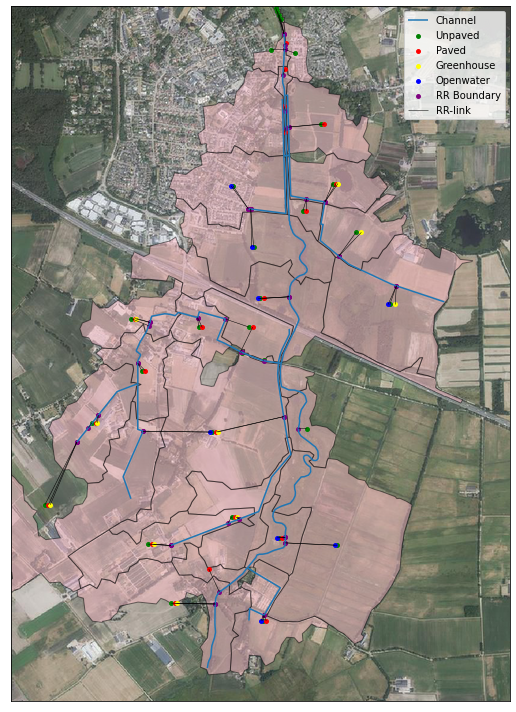

In [24]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(139600, 142400)
ax.set_ylim(391700, 395600)

achtergrond = plt.imread( os.path.join(data_path,'gis/achtergrond.png'))
ax.imshow(achtergrond, extent=(139517.12, 142957.76, 391606.8, 395907.6), interpolation='lanczos')

hydamo.catchments.plot(ax=ax,label='Catchments', edgecolor='black', facecolor="pink", alpha=0.5)
hydamo.branches.plot(ax=ax, label='Channel')
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(ax=ax,markersize=15,color='green',label='Unpaved')
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax,markersize=15,color='red',label='Paved')
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax,markersize=15,color='yellow',label='Greenhouse')
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax,markersize=15,color='blue',label='Openwater')
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(ax=ax, markersize=15, color='purple',label='RR Boundary')
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color='black',linewidth=0.5,label='RR-link')

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor='pink', edgecolor='black',alpha=0.5)
ax.legend(handles=handles.append(poly),labels=labels.append('Catchments'))
fig.tight_layout()

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. Note that both the GUI and Interaktor do not (yet) support RR, so the only way to carry out a coupled simulation is using DIMR.


In [25]:
# Runtime and output settings. Run the first six days of 2000, using a 1 hour timestep for RR.
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20000101
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] = 144.0 * 1 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7

# for RR model
drrmodel.d3b_parameters['Timestepsize'] = 300
drrmodel.d3b_parameters['StartTime'] = "'2000/01/01;00:00:00'" # should be equal to refdate for D-HYDRO
drrmodel.d3b_parameters['EndTime'] = "'2000/01/07;00:00:00'"
drrmodel.d3b_parameters['RestartIn'] = 0
drrmodel.d3b_parameters['RestartOut'] = 0
drrmodel.d3b_parameters['RestartFileNamePrefix'] ='Test'
drrmodel.d3b_parameters['UnsaturatedZone'] = 1
drrmodel.d3b_parameters['UnpavedPercolationLikeSobek213']=-1
drrmodel.d3b_parameters['VolumeCheckFactorToCF']=100000
drrmodel.dimr_path = dimr_path

# Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir= os.path.join(output_path,'MGB_RRFM'), name='moergestels_broek')
rr_writer = DFlowRRWriter(drrmodel, output_dir= os.path.join(output_path,'MGB_RRFM'), name='moergestels_broek')

# Write as model
# The ldb is just for visualising in the interaktor - there is no RR component there.
fm_writer.objects_to_ldb()
fm_writer.write_all()
rr_writer.write_all()

In [26]:
import shutil
shutil.make_archive(os.path.join(output_path,'MGB_RRFM'),'zip',os.path.join(output_path,'MGB_RRFM'))

'D:\\3640.20\\delft3dfmpy.git\\branches\\DSD_workshop_060721\\notebooks\\MGB_RRFM.zip'

In [27]:

# import rasterio
# lugrid = rasterio.open(lu_file)
# meta = lugrid.meta.copy()
# meta.update(compress='lzw')
# meta['crs'] = rasterio.crs.CRS.from_dict(init='epsg:28992')
# lu = lugrid.read(1,)
# lu_2 = lu.copy()
# lu_2[lu==4] = 15
# with rasterio.open(os.path.join(data_path,'rasters/lgn250_greenhouse.tif'), 'w', **meta) as dst:
#     dst.write(lu_2, indexes=1)    

Finished! Start the coupled model by clicking run.bat in the output model.